# Sections

[Objective](#Objective)  
[Exploratory analysis](#Exploratory-analysis)

- [Interest level](#Interest-level)
- [Numeric data](#Numeric-data)
- [Geographic data](#Geographic-data)
- [Nominal data](#Nominal-data)
- [Text data](#Text-data)

    - [Clustering](#Clustering)  
    - [KMeans](#KMeans)
    - [NMF](#NMF)
    - <a href='#agglomerative clustering'>Agglomerative (Ward)</a>

[Scratchpad](#Scratchpad)

# Objective

#### How much interest will a new rental listing on RentHop receive?

In this <a href='https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data'>competition</a>, you will predict how popular an apartment rental listing is based on the listing content like text description, photos, number of bedrooms, price, etc. The data comes from renthop.com, an apartment listing website. These apartments are located in New York City.

### File descriptions

- **```train.json```** - the training set
- **```test.json```** - the test set


### Data fields

- **```bathrooms:```** number of bathrooms
- **```bedrooms:```** number of bathrooms
- **```building_id```**
- **```created```**
- **```description```**
- **```display_address```**
- **```features:```** a list of features about this apartment
- **```latitude```**
- **```listing_id```**
- **```longitude```**
- **```manager_id```**
- **```photos:```** a list of photo links. You are welcome to download the pictures yourselves from renthop's site, but they are the same as imgs.zip. 
- **```price:```** in USD
- **```street_address```**
- **```interest_level:```** this is the target variable. It has 3 categories: 'high', 'medium', 'low'


# Exploratory analysis
[Back to top](#Sections)

In [1]:
from __future__ import print_function, division

In [2]:
from collections import OrderedDict
from collections import Counter
import numpy as np
import pandas as pd
import re
import seaborn as sns
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# %load pp_tools.py
from IPython.display import display, HTML

def pp_bold(str):
    display(HTML('<b>{}</b>'.format(str)))

def pp_listOflist(l):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr>{}</tr>'.format(
                u''.join(u'<td>{}</td>'.format(v) for v in sublist)) for sublist in l))))
    
def pp_dict(d, rows=None):
    if not rows or rows >= len(d):
        display(HTML(
            u'<table>{}</table>'.format(
                u''.join(u'<tr><td><b>{}</b></td><td>{}</td></tr>'.format(k, d[k]) for k in d))))
    else:
        nitems = len(d)
        width = -(-nitems // rows)
        i = 0
        list_ = [[] for _ in range(rows)]
        for _ in range(width):
            for row in range(rows):
                if i < nitems:
                    k, v = d.items()[i]
                    list_[row].extend(['<b>{}</b>'.format(k), v])
                i += 1
        pp_listOflist(list_)

def pp_dictOflist(d):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr><td><b>{}</b></td>{}</tr>'.format(k,
                u''.join(u'<td>{}</td>'.format(v) for v in d[k])) for k in d.keys()))))
    
def pp_dfinfo(df, width=4):
    ncols = len(df.columns)
    width = min(width, ncols)
    depth = -(-ncols // width)
    i = 0
    list_ = [[] for _ in range(depth)]
    for _ in range(width):
        for row in range(depth):
            if i < ncols:
                col = df.columns[i]
                list_[row].extend(['<b>{}</b>'.format(col), df[col].count(), df.dtypes[i]])
            i += 1

    print('{} entries, {} columns'.format(len(df), ncols))
    pp_listOflist(list_)

In [4]:
def pp_progress(s):
    sys.stdout.write('\r{}'.format(s))
    sys.stdout.flush()

Open listings database

In [5]:
from pymongo import MongoClient

In [6]:
client = MongoClient('ec2-34-198-246-43.compute-1.amazonaws.com', 27017)
db = client.renthop
collection = db.listings
pp_bold('{} listings'.format(collection.count()))

Print one of them.

In [7]:
pp_dict(collection.find_one())

listing_id,6818139
_id,58ac97520b0203c6b6436f4c
display_address,Hausman Street
description,"This one WON'T LAST!! Here is a stunning 3 Bedroom, 2 Full Bathroom apartment measuring approximately 1100 sqft! The layout is NOT a railroad with a King Sized master bedroom complete with on suite full bathroom and bay-windows. The 2nd and 3rd bedrooms can fit a Full or Queen sized bed and have over-sized windows. Thee is a second full bathroom with soaking tub off of the main hallway. Open concept kitchen with large island finished in real stone counters and soft close cabinetry plus Stainless Steel industrial sized appliances! Heated hardwood flooring throughout with tons of sunlight and space. Central HVAC means that you never have to be too hot or too cold again!One of the best locations for street parking in Greenpoint! Don't have a car? No Problem, the Nassau G Train and Grand St L train are within reach.Call, Text, Email Taylor now to schedule your private showing. Not exactly what you are looking for? Email me your search criteria, I Specialize in North Brooklyn!-------------Listing courtesy of Miron Properties. All material herein is intended for information purposes only and has been compiled from sources deemed reliable. Though information is believed to be correct, it is presented subject to errors, omissions, changes or withdrawal without notice. Miron Properties is a licensed Real Estate Broker. www.MironProperties.com<a website_redacted"
created,2016-04-03 02:22:45
price,2995
bedrooms,3
interest_level,medium
longitude,-73.9389
photos,https://photos.renthop.com/2/6818139_a50e80ff79c71a1ced4ec103985abdd9.jpg https://photos.renthop.com/2/6818139_a2be68c008aeff88347f97dc0350f85d.jpg https://photos.renthop.com/2/6818139_63166d3d69203d7bd63e8e8bb47db8c6.jpg https://photos.renthop.com/2/6818139_1aba230faec5ed91372bb3996b98acf1.jpg https://photos.renthop.com/2/6818139_af28eb103bab59ec9d929c3657d846e6.jpg https://photos.renthop.com/2/6818139_3637c3737c1286332310476fa4d5b1d8.jpg https://photos.renthop.com/2/6818139_83f4bfb1928581fb9feec154629f62e9.jpg
manager_id,198d2e96429920ff71cd06ddff323713


Copy listing, sans meta data, to dataframe.

In [8]:
%%time
c = collection.find({}, {'_id':0, 'id':0, 'building_id':0, 'manager_id':0, 'listing_id':0, 'photos':0})
df = pd.DataFrame(list(c))
df.interest_level = df.interest_level.astype('category', categories=['low', 'medium', 'high'])

CPU times: user 652 ms, sys: 744 ms, total: 1.4 s
Wall time: 24.6 s


Define functions for creating plots and summary tables.

In [9]:
def pp_counts(series, rows=1, caption=None):
    if caption: pp_bold(caption)
    list_ = [(k, '{:.4f}'.format(v)) for k, v in series.to_dict().items()] 
    dict_ = OrderedDict(sorted(list_, key=lambda x: x[0]))
    pp_dict(dict_, rows)

In [10]:
def percentplot(data, var, title=None, xlabel='', ax=None):
    ax = sns.barplot(x=var, y=var, data=data, estimator=lambda x: len(x) * 100 / len(data))
    ax.set(ylabel="Percent")
    ax.set(xlabel=xlabel if xlabel else '')
    ax.set(title=var if not title else title)
    return ax

In [11]:
def categoryplot(data, feature, category='interest_level', xlabel='', ax=None):
    values = pd.DataFrame()
    grouped = data.groupby([category, feature]).count()
    categories = data[category].cat.categories
    for c in categories:
        values[c] = grouped.xs(c).iloc[:,1]
    values = values.apply(lambda x: x * 100 / np.sum(x), axis=1)
    
    space = 0.1
    n = len(categories)
    width = (1.0 - space) / n
    
    xlabels = None
    for i, cat in enumerate(categories):
        percents = values.loc[:,cat]
        indices = range(len(percents))
        pos = [j - (1.0 - space) / n + i * width for j in indices]
        ax.bar(pos, percents, width=width, label=cat, color=sns.color_palette()[i])
        if i == 0:
            ax.set_xticks(indices)
            ax.set_xticklabels(percents.axes[0])

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    ax.set_ylabel('percent')
    ax.set_xlabel(xlabel if xlabel else '')
    return ax

In [12]:
def feature_hist(df, column, title=None, xlabel='', rotation=None):
    fig = plt.figure(figsize=(10, 8))
    ax1 = percentplot(df, column, title, xlabel=xlabel, ax=plt.subplot(211))
    ax2 = categoryplot(df, column, xlabel=xlabel, ax=plt.subplot(212))
    if rotation:
        for item in ax1.get_xticklabels():
            item.set_rotation(rotation)
        for item in ax2.get_xticklabels():
            item.set_rotation(rotation)
    fig.tight_layout()

## Interest level
[Backl to top](#Sections)

The interest level is heavily skewed to 'low' and 'medium'

high,0.0778,low,0.6947,medium,0.2275


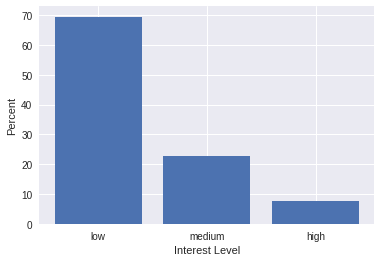

In [13]:
value_counts = df.interest_level.value_counts(normalize=True)
pp_counts(value_counts, caption='Interest levels:')

plt.bar(range(3), value_counts * 100, align='center')
plt.xticks(range(3), df.interest_level.cat.categories)
plt.xlabel('Interest Level')
plt.ylabel('Percent');

## Numeric data
[Back to top](#Sections)

### Price

Time could be a factor with prices, but since all the listings are from a two-month period, I need not be concerned.

In [14]:
pp_dict(OrderedDict([('First listing', np.min(df.created)), ('Last listing', np.max(df.created))]))

First listing,2016-04-01 22:12:41
Last listing,2016-06-29 21:41:47


The highest price is 4.5 million and there are six listings above so $100,000. I think those are all mistakes, because they're for studio, one- and two-bedroom apartments. Drop them.

In [15]:
df[df.price>1e5][['bedrooms', 'bathrooms', 'price', 'interest_level']]

,bedrooms,bathrooms,price,interest_level
11191,2,1.0,4490000,low
12283,0,1.0,111111,high
13494,2,1.0,1150000,low
26830,0,0.0,135000,low
35191,1,1.0,1070000,low
35711,1,1.0,1070000,low


In [16]:
df = df.drop(df[df.price>1e5].index)

Bin prices in increments of 500 up to 10,000, then one bin for everything above that. The range 0 to 10,000 captures >98% of the listings, and of the few outside that range, >98% are low interest.

In [17]:
pp_counts(df[df.price>10000].interest_level.value_counts(normalize=True), 
          caption='Interest levels above $10,000:')

high,0.0023,low,0.9839,medium,0.0138


In [18]:
price_bins = range(0, 10001, 500) + [1e5]
bins = pd.cut(df.price, bins=price_bins)
df['price_bucket'] = bins.apply(lambda x: re.sub('\([0-9]+, ([0-9]+)\]', '\\1', x)).astype(int)

500,0.0001,2000,0.0934,3500,0.1601,5000,0.0545,6500,0.0198,8000,0.0071,9500,0.0020
1000,0.0004,2500,0.1647,4000,0.1123,5500,0.0341,7000,0.0116,8500,0.0035,10000,0.0031
1500,0.0137,3000,0.1970,4500,0.0637,6000,0.0299,7500,0.0080,9000,0.0034,100000,0.0177


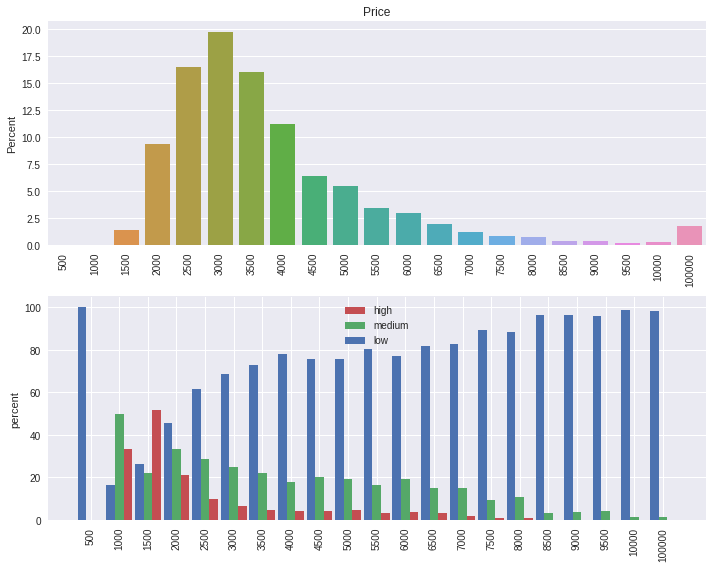

In [19]:
feature_hist(df, 'price_bucket', 'Price', rotation=90)
pp_counts(df.price_bucket.value_counts(normalize=True), rows=3, caption='Price distribution:')

### Bedrooms

Eighty-percent of listings are for studios, or one- and two-bedrooms. The percentage of low, high, medium interest is similar for the different size rentals.

0,0.1920,1,0.3192,2,0.2963,3,0.1474,4,0.0391,5,0.0050,6,0.0009,7,0.0000,8,0.0000


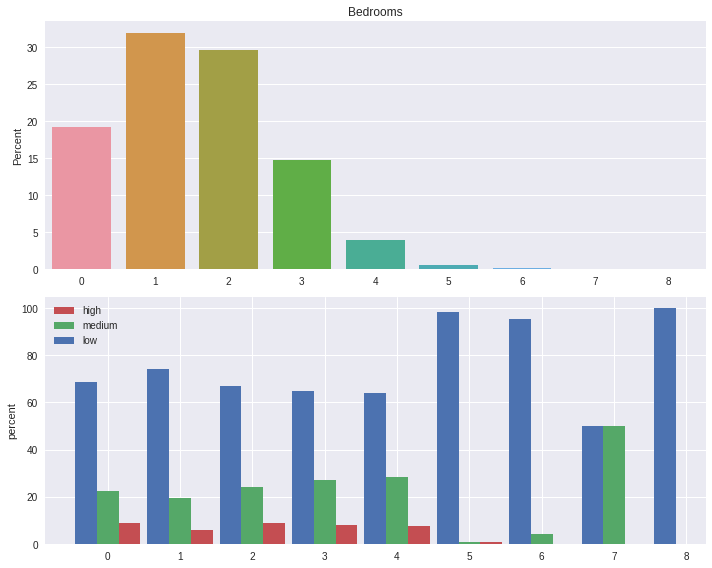

In [20]:
feature_hist(df, 'bedrooms', 'Bedrooms')
pp_counts(df.bedrooms.value_counts(normalize=True), caption='Bedrooms distribution:')

Not surprisingly, larger apartments have higher prices. What's interesting is that all renters appear price-sensitive, with high prices attracting less interest even for larger apartments.

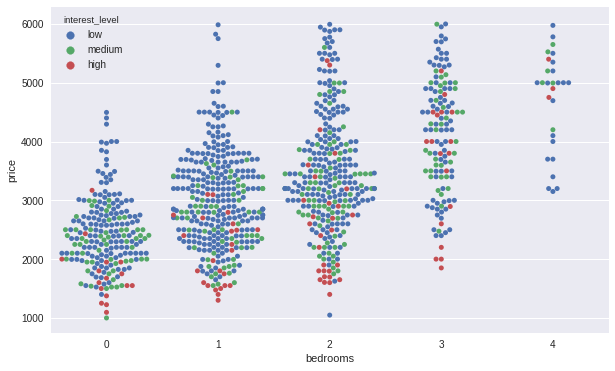

In [21]:
df2 = df[df.price < 6000].copy()
plt.figure(figsize=(10, 6))
sns.swarmplot(x='bedrooms', y='price', hue='interest_level', data=df2.sample(1000));

### Bathrooms

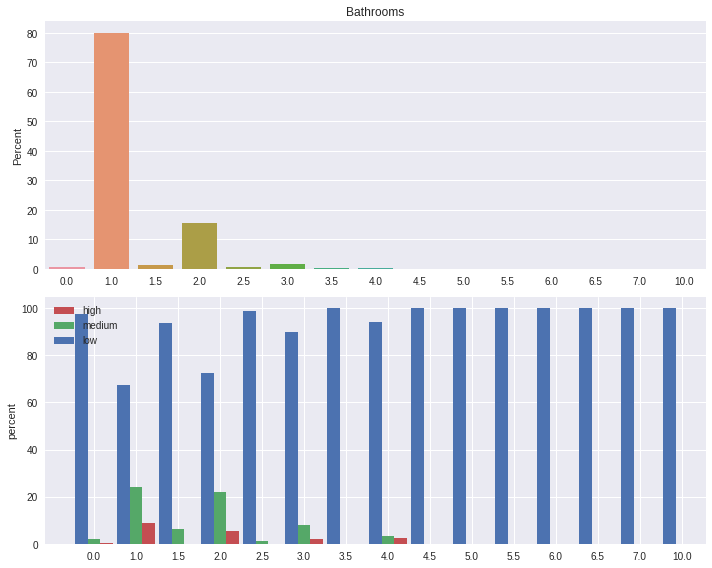

In [22]:
feature_hist(df, 'bathrooms', 'Bathrooms')
pp_counts(df.bathrooms.value_counts(normalize=True), rows=2, caption='Bathrooms distribution:')

## Geographic data
[Back to top](#Sections)

In [23]:
import geopandas as gpd
from shapely.geometry import Point

Drop listings outside New York to make the mapping easier. There are only a few of them.

In [24]:
geo_df = df.copy()
outside_nyc = geo_df[(geo_df.longitude < -74.2) | (geo_df.longitude > -73.7) | (geo_df.latitude < 40.5) | (geo_df.latitude > 40.9)]
geo_df = geo_df.drop(outside_nyc.index)
pp_bold('Dropped {} listings, {} remain'.format(len(outside_nyc), len(geo_df)))

Plot the high, medium and low listings on a map to see if there's any obvious pattern or clustering. First load the shapefile of the five boroughs provide by NYC.gov.

In [25]:
nyc = gpd.GeoDataFrame.from_file('./data/nybb_17a/nybb.shp')
nyc = nyc.to_crs({'init' :'epsg:4326'})

This helper function plots the listing locations.

In [26]:
def plotpoints(df, ax=None, categories=['low', 'medium', 'high'], 
               colors=sns.color_palette('bright'), alpha=.25):
    for i, cat in enumerate(categories):
        points = df[df.interest_level == cat][['longitude', 'latitude']]
        points = gpd.GeoSeries([Point(x, y) for x, y in points.values])
        points.crs = {'init' :'epsg:4326'}
        points.plot(ax=ax, color=colors[i], markersize=5, alpha=alpha)

Plot 5000 listings, selected at random.

Observe there's no strong distinguishing pattern, but there does seems to be slightly higher interest in the lower rent areas (the Bronx, Lower East Side, Upper East Side and Midtown West). That's consistent with the previous observation that interest skews toward lower-priced listings.

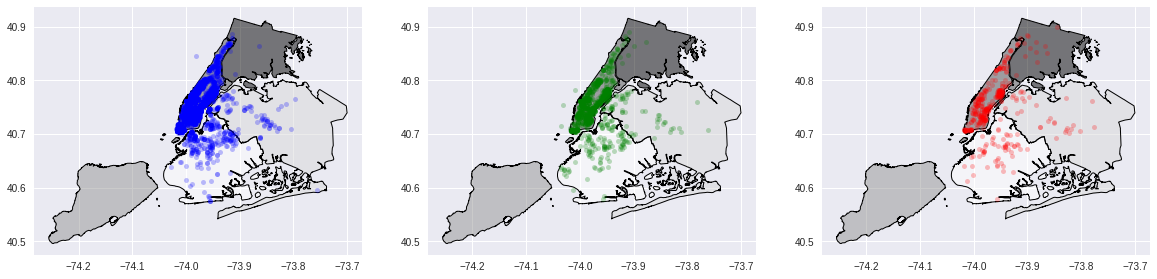

In [27]:
df_sample = geo_df.sample(5000)
plt.figure(figsize=(20, 10))

ax = plt.subplot(131)
ax.set_aspect('equal')
nyc.plot(ax=ax)
plotpoints(df_sample, ax=ax, categories=['low'], colors=['b'])

ax = plt.subplot(132)
ax.set_aspect('equal')
nyc.plot(ax=ax)
plotpoints(df_sample, ax=ax, categories=['medium'], colors=['g'])

ax = plt.subplot(133)
ax.set_aspect('equal')
nyc.plot(ax=ax)
plotpoints(df_sample, ax=ax, categories=['high'], colors=['r'])

Plot an equal number of listings of each type, selected at random. The low interest listings are concentrated in Manhattan. There are a larger portion of medium and high interest listings in lower-prices areas of the Bronx, Brooklyn and Queens.

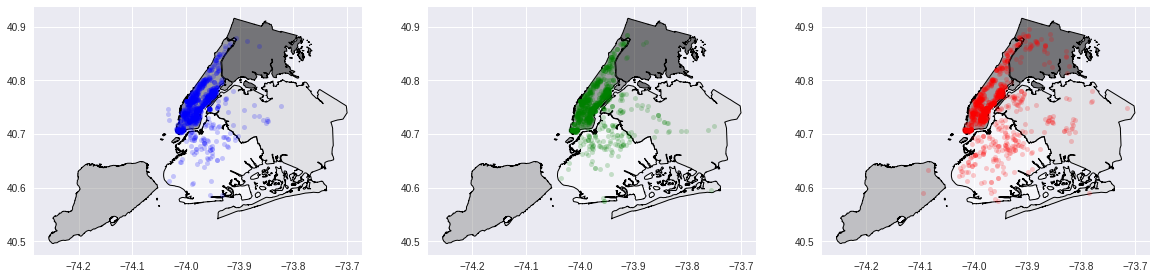

In [28]:
df_low = geo_df[geo_df.interest_level=='low'].sample(1000)
df_medium = geo_df[geo_df.interest_level=='medium'].sample(1000)
df_high = geo_df[geo_df.interest_level=='high'].sample(1000)
plt.figure(figsize=(20, 10))

ax = plt.subplot(131)
ax.set_aspect('equal')
nyc.plot(ax=ax)
plotpoints(df_low, ax=ax, categories=['low'], colors='b', alpha=.2)

ax = plt.subplot(132)
ax.set_aspect('equal')
nyc.plot(ax=ax)
plotpoints(df_medium, ax=ax, categories=['medium'], colors='g', alpha=.2)

ax = plt.subplot(133)
ax.set_aspect('equal')
nyc.plot(ax=ax)
plotpoints(df_high, ax=ax, categories=['high'], colors='r', alpha=.2)

What's the relationship between location, price and interest level?

In [29]:
from mpl_toolkits.mplot3d import Axes3D

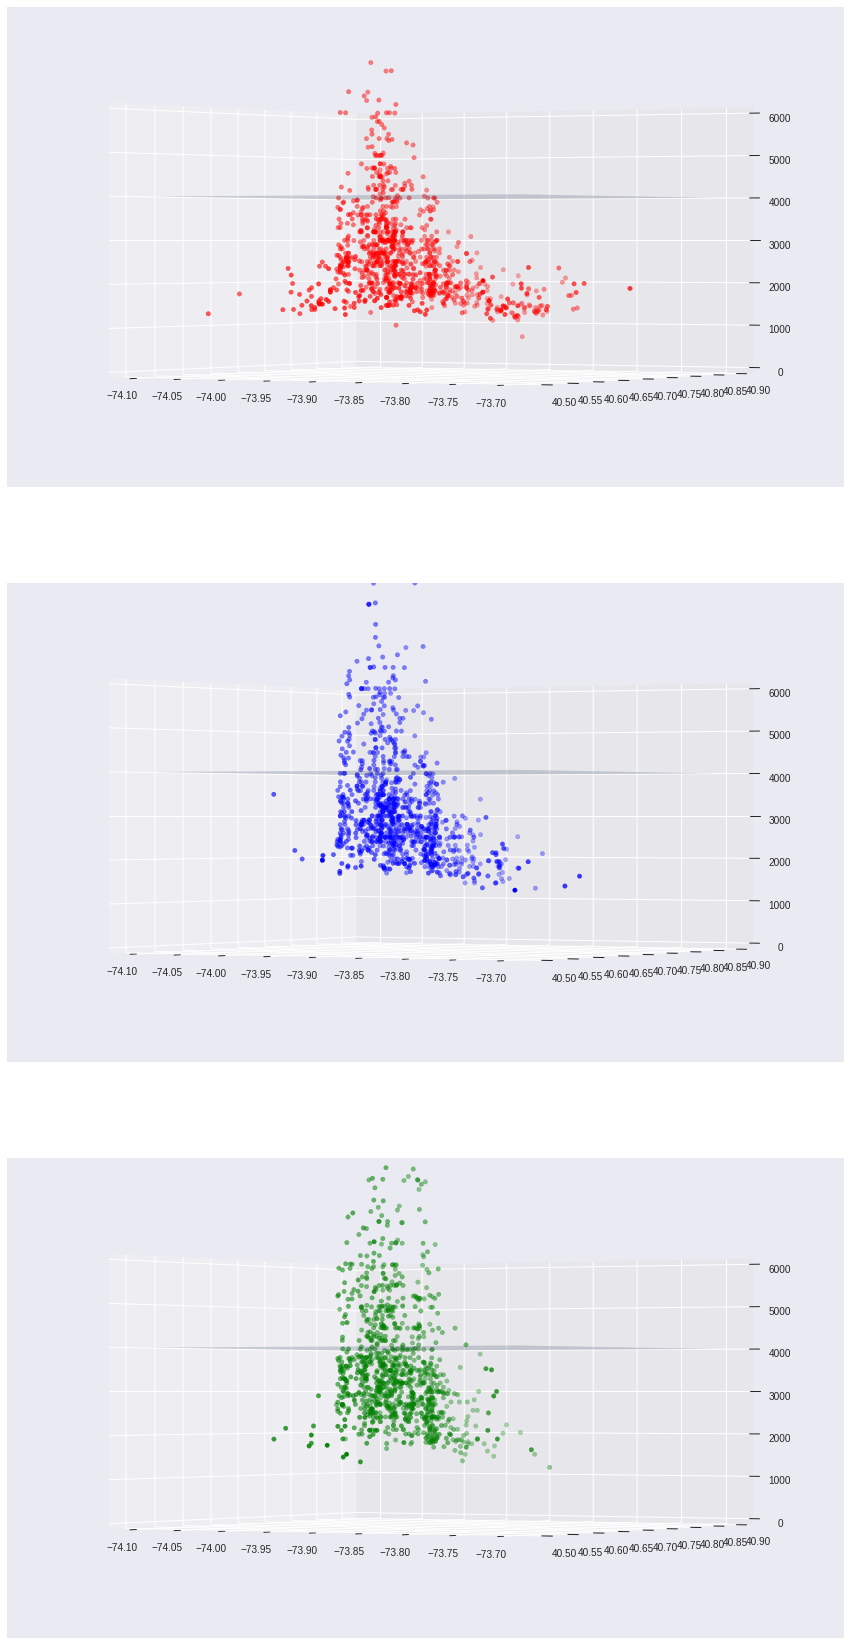

In [30]:
def price3dplot(df, ax, color, zplane=4000, zlimit=(0, 6000)):
    ax.view_init(elev=0)
    ax.set_zlim(*zlimit)
    ax.scatter(df.longitude, df.latitude, df.price, c=[color]*len(df))
    xx, yy = np.meshgrid(np.linspace(-74.1, -73.7, 20), np.linspace(40.5, 40.9, 20))
    ax.plot_surface(xx, yy, [zplane]*len(xx), alpha=0.2)
    return ax

fig = plt.figure(figsize=(15, 30))
price3dplot(df_high, fig.add_subplot(311, projection='3d'), 'r')
price3dplot(df_medium, fig.add_subplot(312, projection='3d'), 'b')
price3dplot(df_low, fig.add_subplot(313, projection='3d'), 'g')
plt.show()

## Nominal data
[Back to top](#Sections)

In [31]:
cat_df = df.copy()

### Street address

Do similarly priced listings at the same address attract the same interest? To find out, identify listings at the same address, group them by size and price bucket, and count how many groups have mixed interest. It's about 50/50. Clearly there's another factor besides location, size and price.

In [32]:
subset = cat_df[cat_df.duplicated(subset='street_address', keep=False)].copy()
groups = subset.groupby(['street_address', 'bedrooms', 'bathrooms', 'price_bucket'])

mixed = []
total = 0
for k, v in groups.groups.items():
    if len(v) > 1:
        total += 1
        if 1 < len(np.unique(cat_df.loc[v].interest_level)):
            mixed.append(v)
            
pp_bold('{0} ({2:.2%}) of similar listings {1} attract mixed interest'.format(len(mixed), total, len(mixed) / total))

Here's an example of mixed interest.

In [33]:
subset.loc[mixed[1]][['created', 'street_address', 'bedrooms', 'bathrooms', 'price', 'interest_level']]

,created,street_address,bedrooms,bathrooms,price,interest_level
26596,2016-04-25 02:51:39,310 East 2nd Street,2,1.0,3507,medium
35391,2016-04-15 05:20:12,310 East 2nd Street,2,1.0,3507,medium
37672,2016-05-18 01:38:18,310 East 2nd Street,2,1.0,3554,low
42538,2016-04-06 07:15:17,310 East 2nd Street,2,1.0,3508,low


The listing's above are close to identical. Could time be a factor? Perhaps interest rises and wanes at different times of the month? To find out, I segment listings by week in the month. The listings are evenly distributed (except for the 'fifth' week which is always a shorter than the others) and the interest levels are constant. It's a small effect, but interest does peak in the first week, then drops steadily.

1,0.2309,2,0.2535,3,0.2500,4,0.2176,5,0.0480


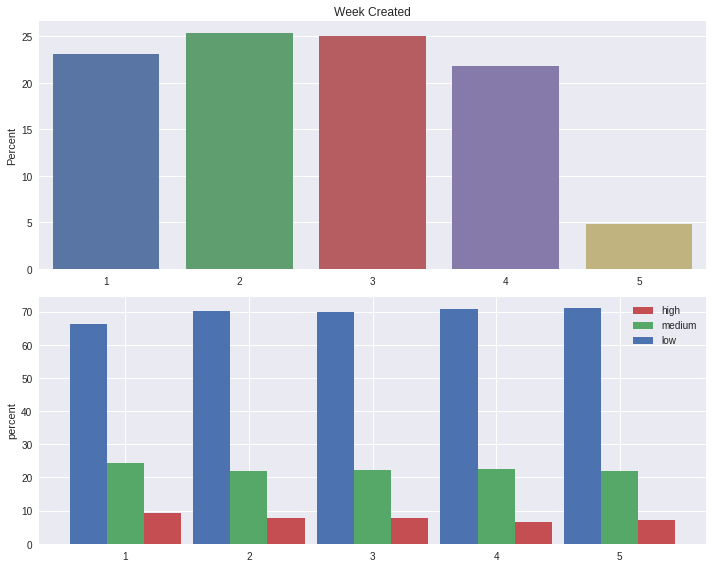

In [34]:
df['week_created'] = pd.to_datetime(df.created).apply(lambda x: -(-x.day // 7))
feature_hist(df, 'week_created', 'Week Created')
pp_counts(df.week_created.value_counts(normalize=True), caption='Weekly distribution:')

What about by day of the month? Observe interest appears to rise and fall periodically. 

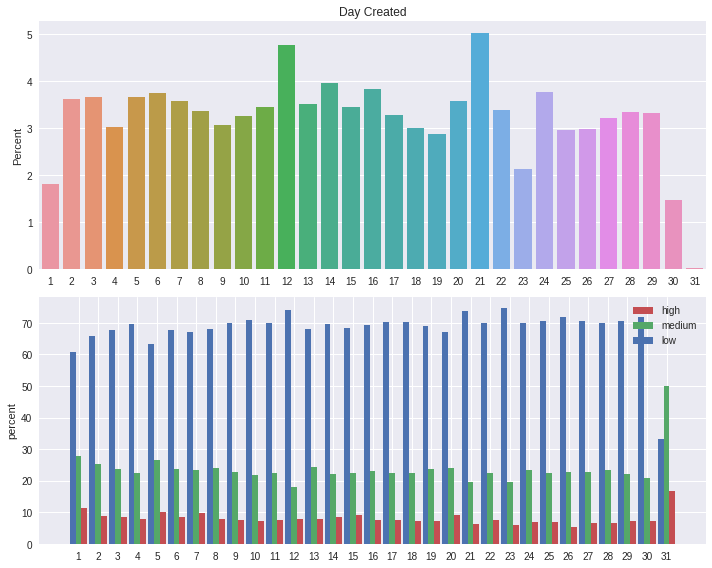

In [35]:
df['day_created'] = pd.to_datetime(df.created).apply(lambda x: x.day)
feature_hist(df, 'day_created', 'Day Created')
pp_counts(df.day_created.value_counts(normalize=True), rows=3, caption='Daily distribution:')

Is it a weekday/weekend cycle? See the plot below where Monday is zero. No, it's not the weekends, thought there is a slight uptick in interest on Thursday.

0,0.0859,1,0.1705,2,0.1908,3,0.1661,4,0.1538,5,0.1409,6,0.0920


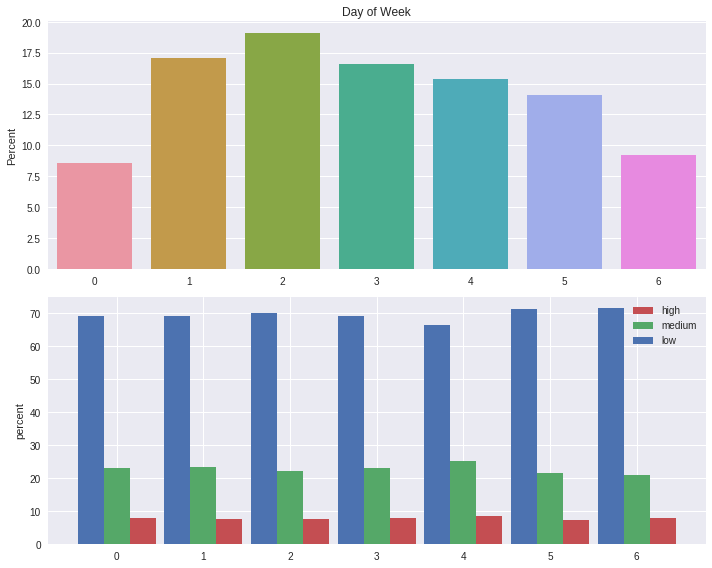

In [36]:
df['dayofweek'] = pd.to_datetime(df.created).apply(lambda x: x.weekday())
feature_hist(df, 'dayofweek', 'Day of Week')
pp_counts(df.dayofweek.value_counts(normalize=True), caption='Day of week distribution:')

## Text data
[Back to top](#Sections)

In [37]:
import nltk.corpus
import nltk.stem.porter
import re

The raw listing descriptions are polluted with HTML tags and formatting quirks:
- **```scrub```** removes meta data, symbols and extraneous text, and repairs formatting errors
- **```tokenize```** converts scrubbed text to words (tokens) with optional stemming.

In [38]:
regexs = [
    ('<!\[CDATA\[|<[^>]+>|<a.*?website_redacted', ' '), # drop HTML tags (e.g., <br>)
    ('&[a-z]+;', ' '), # drop HTML entities (e.g., &gt;)
    ('([A-Z]{2})([A-Z][a-z])', r'\1 \2'), # fix mixed caps: AMENITIESDoorman -> AMENITIES Doorman
    ('([a-z])([A-Z])', r'\1 \2'), # fix mixed caps (e.g., WasherDryer -> Washer Dryer)
    ('([0-9]{4})([a-zA-Z]{2})', r'\1 \2'), # fix mixed text and numbers: 9999XX -> 9999 XX
    ('([a-zA-Z]{2})([0-9]{2})', r'\1 \2'), # fix mixed text and numbers: XX99 -> XX 99
    (r'[/"`.,!?;:=&~+_#<>${}\r\*\(\)\|\[\]\-\\]', ' '), # drop punctuation
    ('[0-9]{2}[0-9]+[^a-zA-Z]', ' '), # drop long digit sequences
    (r'([^a-zA-Z])\'', r'\1'), # drop orphan apostrophe
    (r'\'([^a-zA-Z])', r'\1'), # drop orphan apostrophe
    # convert subway lines to longer words that survive tokenization
    (r' ([ABCDEFMGLJZNQRWS]) ', r' \1Line '),
    (r' ([ABCDEFMGLJZNQRWS]) ', r' \1Line '),
    (r' 1 ', ' one '),   (r' 2 ', ' two '),
    (r' 3 ', ' three '), (r' 4 ', ' four '),
    (r' 5 ', ' five '),  (r' 6 ', ' six '),
    (r' 7 ', ' seven '),
]

def scrub(text):
    for a, b in regexs:
        text = re.sub(a, b, text)
    return text

In [39]:
stemmer = nltk.stem.porter.PorterStemmer()
stems = {}
def get_stem(w):
    stem = stems.get(w, None)
    if not stem:
        stem = stemmer.stem(w).replace('\'', '')
        stems[w] = stem
    return stem

STOP_WORDS = """
    apartment unit
    email call contact text com kagglemanager@renthop www
    """
stops = set(STOP_WORDS.split()).union(nltk.corpus.stopwords.words('english'))

def tokenize(text, stemming=False):
    tokens = []
    for word in text.encode('ascii', 'ignore').lower().split():
        if word in stops:
            continue
        elif stemming:
            word = get_stem(word)
            if word in stops:
                continue
        tokens.append(word)
    return ' '.join(tokens)

Scrub and tokenize the listings.

In [40]:
%%time
df['scrubbed'] = df.description.apply(lambda x: scrub(x))
df['tokens'] = df.scrubbed.apply(lambda x: tokenize(x))

CPU times: user 12 s, sys: 528 ms, total: 12.5 s
Wall time: 12.5 s


Here's what we're left with.

In [41]:
descriptions = df.tokens.apply(lambda x: x.split() if x else np.nan).dropna()
unique_words = Counter([word for listing in descriptions for word in listing])
repeat_words = sum([1 for word, count in unique_words.items() if count > 1])
total_words = np.sum(descriptions.apply(lambda x: len(x)))
median_len = np.median(descriptions.apply(lambda x: len(x)))
pp_dict(OrderedDict([
        ('descriptions', len(descriptions)), 
        ('total words', total_words), 
        ('unique words', len(unique_words)),
        ('repeated words', repeat_words),
        ('median length', np.round(median_len))]))

descriptions,45680
total words,2895307
unique words,24422
repeated words,15491
median length,56.0


 And here's an example of how the text is transformed.

In [102]:
example = OrderedDict()
for col in ['description', 'scrubbed', 'tokens']:
    example[col] = df[col][282].replace('<', '&lt;').replace('>', '&gt;')
pp_dict(example)

description,"Loft like 12 ft CeilingsOversized, energy efficient windowsGranite & Porcelain gourmet KitchenPolished chrome fixtures throughoutMinutes from A,C,2,3,4,5,J,Z,R Trains!Minutes from Wall St, Seaport, Stone St<br /><br />Elevator / 24 Hr DoormanFitness CenterGreat Roofdeck for summerShoot Pool in Tenant's LoungeImmaculately restored Lobby<br /><br />To schedule a viewing please call or text Justin @ 498-701-6489 or email at kagglemanager@renthop.com<br /><br /><p><a website_redacted"
scrubbed,Loft like 12 ft Ceilings Oversized energy efficient windows Granite Porcelain gourmet Kitchen Polished chrome fixtures throughout Minutes from ALine CLine two three four five JLine ZLine RLine Trains Minutes from Wall St Seaport Stone St Elevator 24 Hr Doorman Fitness Center Great Roofdeck for summer Shoot Pool in Tenant's Lounge Immaculately restored Lobby To schedule a viewing please call or text Justin @ or email at kagglemanager@renthop com
tokens,loft like 12 ft ceilings oversized energy efficient windows granite porcelain gourmet kitchen polished chrome fixtures throughout minutes aline cline two three four five jline zline rline trains minutes wall st seaport stone st elevator 24 hr doorman fitness center great roofdeck summer shoot pool tenant's lounge immaculately restored lobby schedule viewing please justin @


## Clustering
[Back to top](#Sections)

Are there any insights to be gained from the listing text? Let's see what NLP clustering can tell us. First import all the scikit-learn modules we'll be using.

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.externals import joblib

Create the requisite TF-IDF matix of [n_samples, n_features]. I hand-tuned **max_df** and **max_df** to elmininate rare words, and also common words that appear so often as to be meaingless. The resulting matrix has ~1300 n-grams. 

In [103]:
params = {
    'min_df' : .01, 'max_df' : 0.8, 'max_features' : 200000, 'ngram_range' : (1,2)
    }
tfidf_vectorizer = TfidfVectorizer(**params)
%time tfidf_matrix = tfidf_vectorizer.fit_transform(df.tokens)
print(tfidf_matrix.shape)

CPU times: user 9.61 s, sys: 252 ms, total: 9.86 s
Wall time: 10.2 s
(49346, 1325)


### KMeans
[Back to top](#Sections)

With KMeans, you specify how many clusters to create. As I don't know beforehand, try different values and examine the resulting silhouette and inertia scores. To save time, use a subset of the data and precompute the pairwise distances.  Observe the elbow is at around 10 clusters.

In [105]:
km_sample = tfidf_matrix[:5000]
km_distances = pairwise_distances(km_sample, metric='euclidean')

In [106]:
km_scores = { 'silhouette' : [], 'inertia' : [] }
km_params = { 'n_clusters' : 0, 'random_state' : 4444, 'init' : 'k-means++', 'n_jobs' : -1}
km_range = range(2, 21)
for n_clusters in km_range:
    pp_progress('Fitting KMeans with {} clusters ... '.format(n_clusters))
    km_params['n_clusters'] = n_clusters
    km = KMeans(**km_params)
    km.fit(km_sample)
    km_scores['silhouette'].append(silhouette_score(km_distances, km.labels_, metric='precomputed'))
    km_scores['inertia'].append(km.inertia_)
print('done')

Fitting KMeans with 20 clusters ... done


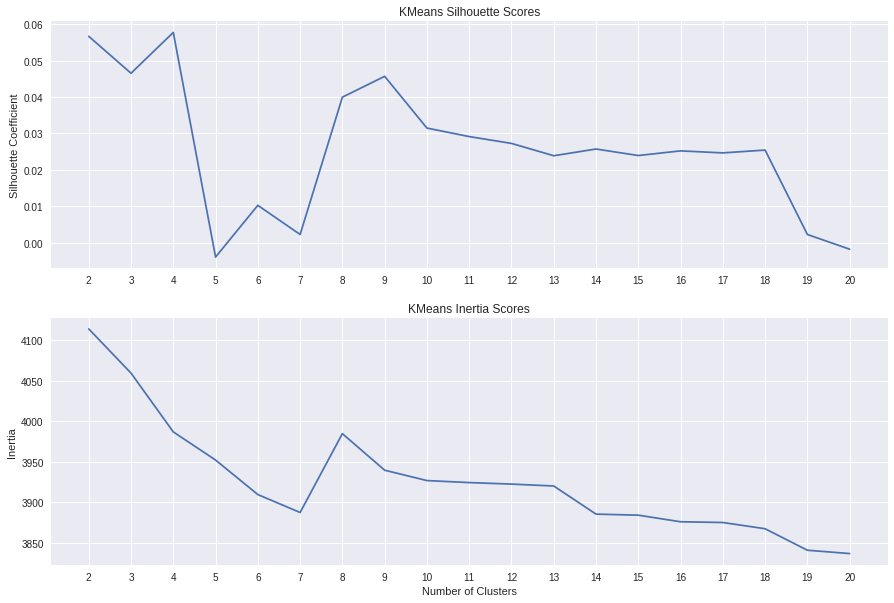

In [134]:
plt.figure(figsize=(15, 10))

ax = plt.subplot(211)
plt.plot(km_range, km_scores['silhouette'])
plt.xticks(km_range, km_range)
ax.set(title='KMeans Silhouette Scores', ylabel='Silhouette Coefficient')

ax = plt.subplot(212)
plt.plot(km_range, km_scores['inertia'])
plt.xticks(km_range, km_range)
ax.set(title="KMeans Inertia Scores", xlabel='Number of Clusters', ylabel='Inertia')
plt.show()

Now we've established the 'optimum' number of clusters, fit the entire data set

In [108]:
%%time
params = { 'n_clusters' : 7, 'random_state' : 4444,  'init' : 'k-means++', 'n_jobs' : -1 }
km = KMeans(**params)
km.fit(tfidf_matrix)

CPU times: user 1.64 s, sys: 384 ms, total: 2.02 s
Wall time: 10min 24s


In [109]:
joblib.dump(km, './data/KMeans.pkl')
#km = joblib.load('./data/KMeans.pkl')

['./data/KMeans.pkl']

The table below contains the ten most common words in each cluster. Clusters 0, 6, and 7 appear to identify specific agencies (Bond, Cooper and Miron). Of the remaining, these have easily identifed features:
- cluster 2: doorman, on-site laundry
- cluster 3: washer/dryer, stainless steel appliances
- cluster 5: fitness center, lounge, concierge
- cluster 8: one month free

In [135]:
topics = {}
words = np.asarray(tfidf_vectorizer.get_feature_names())
for r in km.cluster_centers_:
    feature_importances = r.argsort()[::-1]
    topics[len(topics)] = ', '.join(words[feature_importances][:10])
pp_dict(topics, rows=4)

How do the clusters align with our target variable? It's a mixed bag. The Cooper cluster (six) is strongly correlated with low interest, but it's only 1% of the data. So is cluster one, but the correlation is not as strong. Of the others, clusters two, four, eight deviate from the overall percentages.

0,0.1058,1,0.0840,2,0.2227,3,0.0728,4,0.0144,5,0.1398,6,0.3604


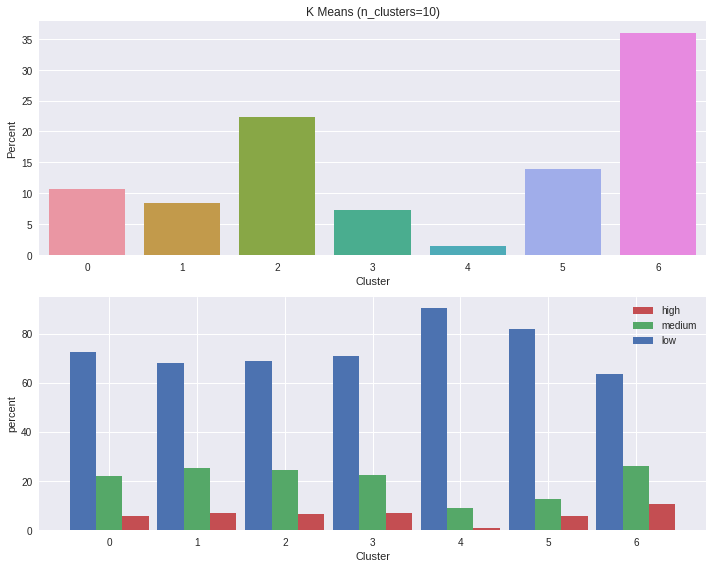

In [113]:
df['km_clusters'] = km.labels_.tolist()
feature_hist(df, 'km_clusters', 'K Means (n_clusters=10)', xlabel='Cluster')
pp_counts(df.km_clusters.value_counts(normalize=True), caption='K Means Clusters:', rows=1)

### NMF
[Back to top](#Sections)

KMeans gave mixed results, so try NMF. It also requires that you specify how many clusters to create, so again try several and plot the results. The curve flattens at 22 clusters.

In [114]:
nmf_sample = tfidf_matrix[:5000]
nmf_distances = pairwise_distances(nmf_sample, metric='euclidean')

In [115]:
nmf_scores = { 'silhouette' : [] }
nmf_params = { 'n_components' : 0, 'random_state' : 4444 }
nmf_range = range(2, 31)

for n_components in nmf_range:
    pp_progress('Fitting NMF with {} clusters ... '.format(n_components))
    nmf_params['n_components'] = n_components
    nmf = NMF(**nmf_params)
    nmf_factors = nmf.fit_transform(nmf_sample)
    nmf_labels = nmf_factors.argmax(axis=1)
    nmf_scores['silhouette'].append(silhouette_score(nmf_distances, nmf_labels, metric='precomputed'))
print('done')

Fitting NMF with 30 clusters ... done


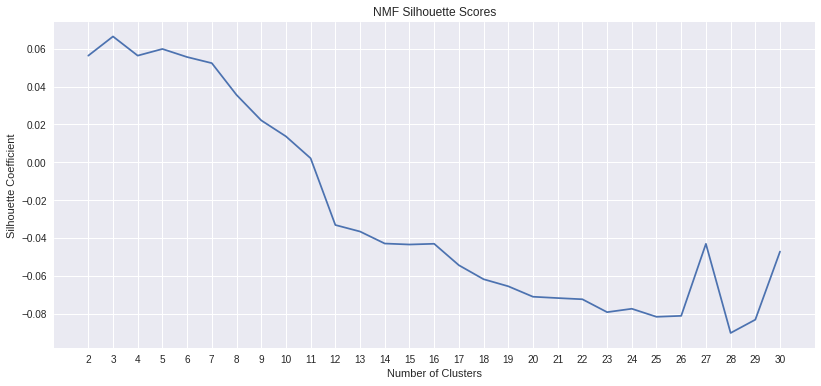

In [116]:
plt.figure(figsize=(30,6))
ax = plt.subplot(121)
plt.plot(nmf_range, nmf_scores['silhouette'])
plt.xticks(nmf_range, nmf_range)
ax.set(title='NMF Silhouette Scores', xlabel='Number of Clusters', ylabel='Silhouette Coefficient')
plt.show()

In [117]:
%%time
params = { 'n_components' : 22, 'random_state' : 4444 }
nmf = NMF(**params)
nmf_factors = nmf.fit_transform(tfidf_matrix)

CPU times: user 16.7 s, sys: 13.7 s, total: 30.4 s
Wall time: 13.9 s


Here are the most common words in each cluster.

In [118]:
topics = {}
words = np.asarray(tfidf_vectorizer.get_feature_names())
for r in nmf.components_:
    feature_importances = r.argsort()[::-1]
    topics[len(topics)] = ', '.join(words[feature_importances][:10])
pp_dict(topics, rows=6)

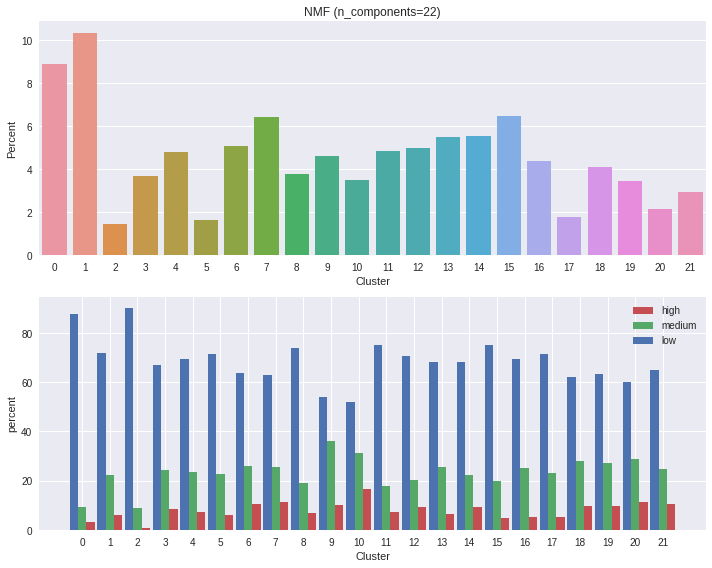

In [120]:
df['nmf_clusters'] = np.argmax(nmf_factors, axis=1)
feature_hist(df, 'nmf_clusters', title='NMF (n_components=22)', xlabel='Cluster')
pp_counts(df.nmf_clusters.value_counts(normalize=True), caption='NMF Clusters:', rows=3)

<a id='agglomerative clustering'></a>
### Agglomerative (Ward) 
[Back to top](#Sections)

In [131]:
ward_sample = tfidf_matrix[:5000].toarray()
ward_distances = pairwise_distances(ward_sample, metric='euclidean')

In [132]:
ward_scores = { 'silhouette' : [] }
ward_params = { 'n_clusters' : 0, 'linkage' : 'ward'}
ward_range = range(2, 21)

for n_components in ward_range:
    pp_progress('Fitting Ward with {} clusters ... '.format(n_components))
    ward_params['n_clusters'] = n_components
    ward = AgglomerativeClustering(**ward_params)
    ward.fit(ward_sample)
    ward_scores['silhouette'].append(silhouette_score(ward_distances, ward.labels_, metric='precomputed'))
print('done')

Fitting Ward with 30 clusters ... done


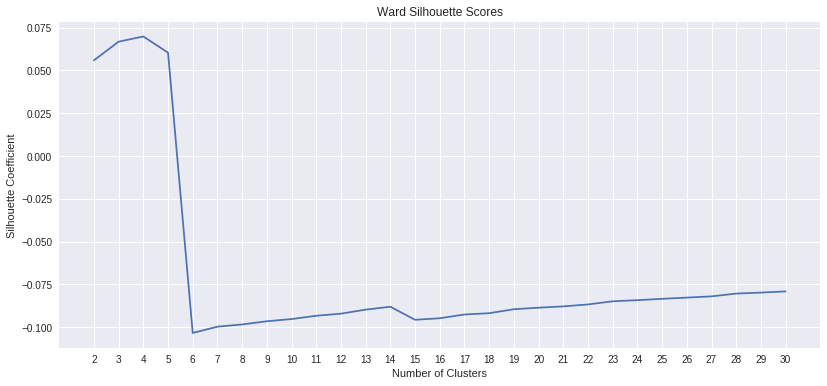

In [136]:
plt.figure(figsize=(30,6))
ax = plt.subplot(121)
plt.plot(ward_range, ward_scores['silhouette'])
plt.xticks(ward_range, ward_range)
ax.set(title='Ward Silhouette Scores', xlabel='Number of Clusters', ylabel='Silhouette Coefficient')
plt.show()

In [158]:
%%time
ward_total = 20000
params = { 'n_clusters' : 6, 'linkage' : 'ward' }
ward = AgglomerativeClustering(**params)
ward.fit(tfidf_matrix[:ward_total].toarray())

CPU times: user 6min 36s, sys: 2.31 s, total: 6min 38s
Wall time: 6min 40s


In [167]:
ward.children_[5]

array([   27, 20004])

In [ ]:
topics = {}
words = np.asarray(tfidf_vectorizer.get_feature_names())
for r in nmf.components_:
    feature_importances = r.argsort()[::-1]
    topics[len(topics)] = ', '.join(words[feature_importances][:10])
pp_dict(topics, rows=6)

0.0,0.4780,1.0,0.3100,2.0,0.0799,3.0,0.0138,4.0,0.1045,5.0,0.0138


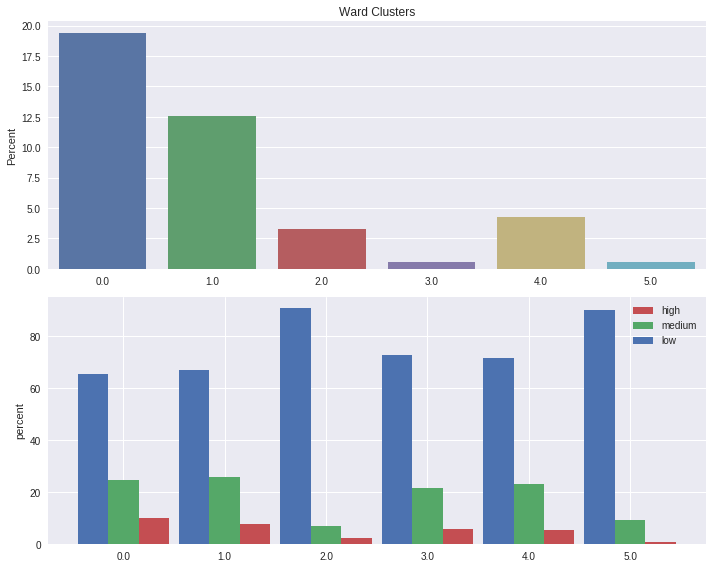

In [151]:
df['ward_clusters'] = np.append(ward.labels_, [np.nan]*(len(df)-ward_total))
feature_hist(df, 'ward_clusters', 'Ward Clusters')
pp_counts(df.ward_clusters.value_counts(normalize=True), caption='Ward Clusters:')

In [175]:
sample.nmf_clusters

0       9
1       0
2      16
3      19
4       3
5      18
6      10
7      12
8      13
9      10
10     13
11      9
12      6
13      5
14      9
15      2
16      6
17     16
18      1
19      7
20     11
21      9
22      6
23     15
24     14
25     10
26     13
27      3
28      6
29      4
       ..
970    13
971    12
972     9
973    21
974    19
975     0
976     0
977    11
978    21
979    12
980     8
981     8
982     9
983     1
984     4
985     1
986    16
987    10
988    13
989     7
990    18
991    17
992    15
993     9
994     3
995    12
996    11
997     8
998     9
999    10
Name: nmf_clusters, dtype: int64

In [178]:
import json

def get_size(bed, bath):
    if 0 == bed:
        return 'Studio'
    elif int(bath) == bath:
        return '{}BR, {}BA'.format(bed, int(bath))
    else:
        return '{}BR, {}BA'.format(bed, bath)

cols = ['km_clusters', 'nmf_clusters', 'ward_clusters', 'price', 'street_address', 
        'bedrooms', 'bathrooms', 'description']
sample = df.sample(1000, random_state=4444)[cols].reset_index(drop=True)
sample.ward_clusters = sample.ward_clusters.fillna(-1)
sample['size'] = [get_size(sample.bedrooms[i], sample.bathrooms[i]) for i in range(len(sample))]
sample.to_json('./app/nodes.json', orient='index')

km_clusters = []
for i, r in enumerate(km.cluster_centers_):
    count = len(sample[sample.km_clusters==i])
    feature_importances = r.argsort()[::-1]
    top_words = ', '.join(words[feature_importances][:10])
    km_clusters.append({'name' : i, 'size' : count, 'words' : top_words})
with open('./app/KMeans_clusters.json', 'w') as fp:
    json.dump({'name' : 'root', 'children' : km_clusters}, fp);
    
nmf_clusters = []
for i, r in enumerate(nmf.components_):
    count = len(sample[sample.nmf_clusters==i])
    feature_importances = r.argsort()[::-1]
    top_words = ', '.join(words[feature_importances][:10])
    nmf_clusters.append({'name' : i, 'size' : count, 'words' : top_words})
with open('./app/NMF_clusters.json', 'w') as fp:
    json.dump({'name' : 'root', 'children' : nmf_clusters}, fp);
    
ward_clusters = []
for i in range(ward.n_clusters):
    count = len(sample[sample.ward_clusters==i])
#    feature_importances = r.argsort()[::-1]
#    top_words = ', '.join(words[feature_importances][:10])
    top_words = ''
    ward_clusters.append({'name' : i, 'size' : count, 'words' : top_words})
with open('./app/Ward_clusters.json', 'w') as fp:
    json.dump({'name' : 'root', 'children' : ward_clusters}, fp);

#### DBSCAN

In [271]:
from sklearn.preprocessing import normalize
tfidf_normed = normalize(tfidf_matrix)

In [ ]:
%%time
from sklearn.preprocessing import StandardScaler
params = { 'eps' : 5.0, 'min_samples' : 4, 'n_jobs' : -1}
n_clusters = []
#for eps in range(900, 1000):
#    params['eps']=eps/1000.0
dbscan = DBSCAN(**params)
dbscan.fit(tfidf_normed)
#    n_clusters.append(len(dbscan.labels_))
    

-1,0.0004,0,0.0148,1,0.9690,2,0.0158


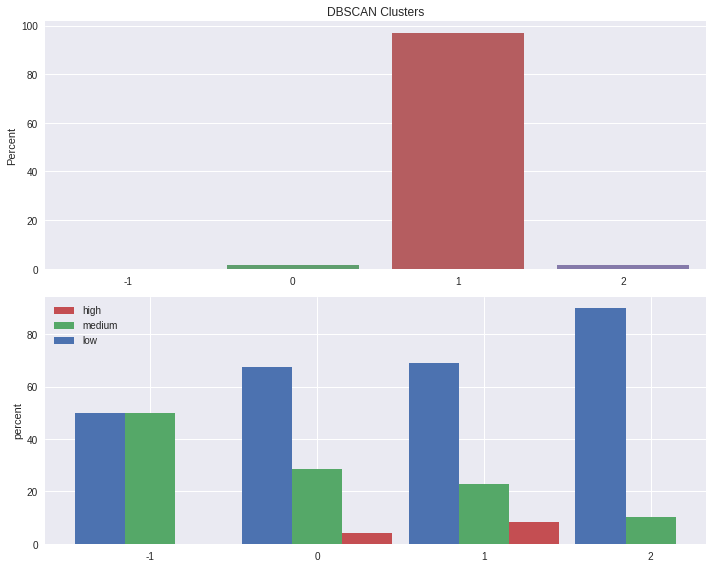

In [270]:
clusters = dbscan.labels_
temp = df[:5000].copy()
temp['clusters'] = clusters
feature_hist(temp, 'clusters', 'DBSCAN Clusters')
pp_counts(temp.clusters.value_counts(normalize=True), caption='DBSCAN Clusters:')

## Scratchpad
[Back to top](#Sections)

In [250]:
pos = 0

False,0.8734,True,0.1266


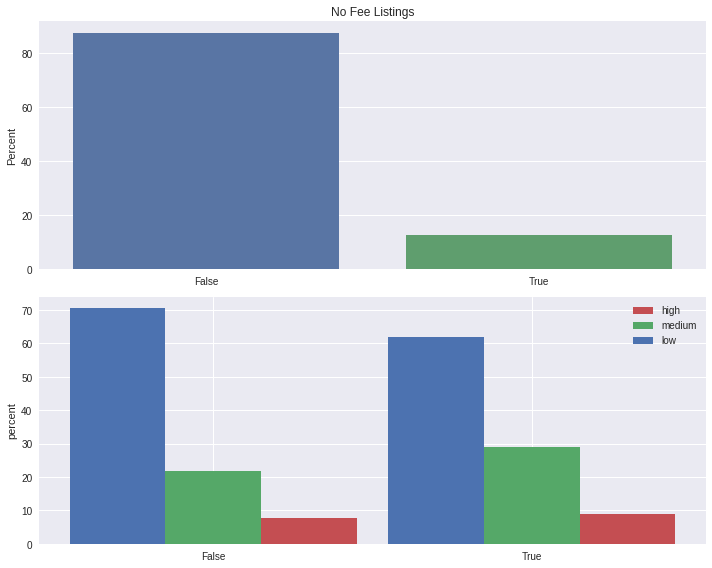

In [439]:
df['no_fee'] = df.clean_description.apply(lambda x: x.lower().find('no fee') >= 0)
feature_hist(df, 'no_fee', 'No Fee Listings')
pp_counts(df.no_fee.value_counts(normalize=True), caption='No Fee listings:')

In [74]:
from textblob import TextBlob

In [37]:
blob = TextBlob(df.description[0])
blob.sentiment.polarity

0.1389030612244898

In [38]:
df['polarity'] = df.apply(lambda x: TextBlob(x.description).sentiment.polarity, axis=1)

In [ ]:
df['subjectivity'] = df.apply(lambda x: TextBlob(x.description).sentiment.subjectivity, axis=1)

In [ ]:
plt.figure(figsize=(10, 4))
sns.lmplot('subjectivity', 'polarity', df[df.price<6000].sample(2000), hue='interest_level')

In [ ]:
c = Counter
for i, text in enumerate(df.description):
    try:
        blob = TextBlob(text)
    except:
        print(i, 'failed')
    

In [ ]:
np.min(cat_df.created)

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time

In [ ]:
from collections import namedtuple
df_text = df[df.description != ''].copy()
Data = namedtuple('Data', ['data', 'target'])
data = Data(df_text.description, df_text.interest_level)

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

In [ ]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
}

In [ ]:
# find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(data.data, data.target)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
